Using cache found in C:\Users\Admin/.cache\torch\hub\B-cos_B-cos-v2_main
C:\Users\Admin\AppData\Local\Temp\ipykernel_64016\3655032040.py:60: UserWarning: Input tensor did not require grad! Has been set automatically to True!
  warnings.warn(


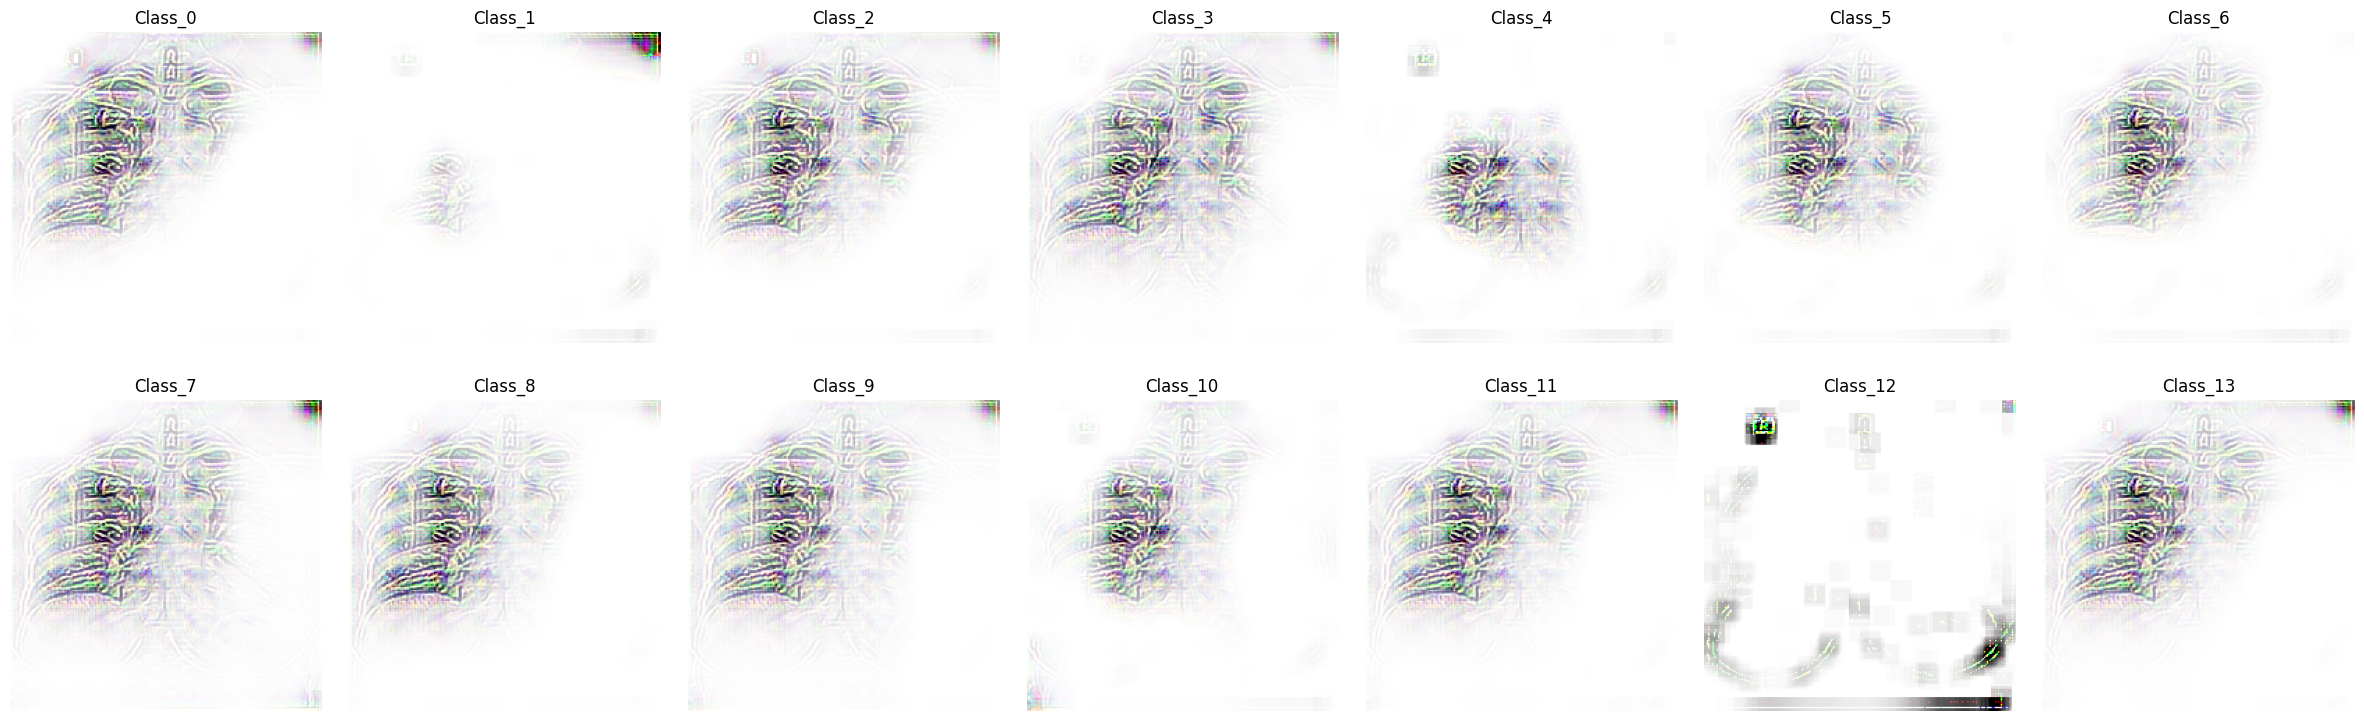

Probabilities: tensor([[0.0021, 0.0005, 0.0016, 0.0014, 0.0005, 0.0008, 0.0008, 0.0018, 0.0017,
         0.0016, 0.0009, 0.0015, 0.0002, 0.0021]])
Binary Predictions: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)


In [1]:
import os
import pickle
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, accuracy_score
import numpy as np
import pandas as pd
from torchvision.transforms import functional as TF
from PIL import Image
import pydicom 
import random
import matplotlib.pyplot as plt
import warnings
from typing import Dict, Any
from libraries_multilabel.bcosconv2d import NormedConv2d
from bcos.common import BcosUtilMixin
from bcos.models.resnet import BcosResNet, Bottleneck

from torchvision.models.resnet import ResNet
''

np.random.seed(0)
random.seed(0)
torch.manual_seed(0)

model_path_better = r"C:\Users\Admin\Documents\MasterThesis\results\VinBigData\ResNet_Bcos\no_nosamp\seed_0\pneumonia_detection_model_resnet_bcos_bestf1_1.pth"

criterion = nn.BCEWithLogitsLoss()

class CustomModelWrapper(BcosUtilMixin):
    def __init__(self, pretrained_model):
        super().__init__()
        self.model = pretrained_model

    def forward(self, x):
        return self.model(x)

    def modules(self):
        return self.model.modules()


    # need to change to sigmoid!!!! for actually using it
    # Override the explain method to use the model attribute correctly
    def explain(
        self,
        in_tensor,
        idx=None,
        explain_all_classes=False,
        threshold=0.5,
        **grad2img_kwargs,
    ) -> "Dict[str, Any]":
        # Call the explain method from CustomBcosMixin but use self.model for predictions
        if in_tensor.ndim == 3:
            raise ValueError("Expected 4-dimensional input tensor")
        if in_tensor.shape[0] != 1:
            raise ValueError("Expected batch size of 1")
        if not in_tensor.requires_grad:
            warnings.warn(
                "Input tensor did not require grad! Has been set automatically to True!"
            )
            in_tensor.requires_grad = True  # nonsense otherwise
        if self.model.training:  # noqa
            warnings.warn(
                "Model is in training mode! "
                "This might lead to unexpected results! Use model.eval()!"
            )

        result = dict()
        self.model.eval()
        with torch.enable_grad(), self.explanation_mode():
            # Manually set explanation mode for the wrapped model
            for m in self.model.modules():
                if hasattr(m, "set_explanation_mode"):
                    m.set_explanation_mode(True)

            # fwd + prediction using self.model
            out = self.model(in_tensor)  # Use self.model for predictions
            probs = torch.sigmoid(out)
            
            binary_preds = (probs > 0.5).int()

            result["probabilities"] = probs.detach().cpu()
            result["binary_predictions"] = binary_preds.detach().cpu()

            grads = []
            contribution_maps = []

            for class_idx in range(out.shape[1]):
                grad = torch.autograd.grad(
                    outputs=out[0, class_idx],
                    inputs=in_tensor,
                    retain_graph=True,
                    create_graph=False,
                    only_inputs=True,
                )[0]
                
                grads.append(grad)
                contribution_maps.append((in_tensor * grad).sum(1).squeeze(0))

            result["contribution_maps"] = torch.stack(contribution_maps)
            result["dynamic_linear_weights"] = torch.stack(grads)

            result["explanations"] = {}
            if explain_all_classes:
                # Generate explanations for all classes
                for idx in range(out.shape[1]):
                    result["explanations"][f"class_{idx}"] = self.gradient_to_image(
                        in_tensor[0], grads[idx][0], **grad2img_kwargs
                    )
            else:
                # Generate explanations only for predicted classes
                active_classes = torch.where(binary_preds)[0]
                for idx in active_classes:
                    result["explanations"][f"class_{idx}"] = self.gradient_to_image(
                        in_tensor[0], grads[idx][0], **grad2img_kwargs
                    )

            # Manually reset explanation mode for the wrapped model
            for m in self.model.modules():
                if hasattr(m, "set_explanation_mode"):
                    m.set_explanation_mode(False)

        return result

    
# Load the pretrained model
pretrained_model = torch.hub.load('B-cos/B-cos-v2', 'resnet50', pretrained=True)
pretrained_model.fc.linear = NormedConv2d(2048, 14, kernel_size=(1, 1), stride=(1, 1), bias=False) # code from B-cos paper reused to adjust network
state_dict_better = torch.load(model_path_better)
pretrained_model.load_state_dict(state_dict_better)
pretrained_model.eval()
custom_wrapper = CustomModelWrapper(pretrained_model)

# Load your image

image_path = r"D:\vinbigdata-chest-xray-abnormalities-detection\train_png_224\0b78363604f4d81c3e27f90bd3066df6.png"
image = Image.open(image_path).convert("RGB")
tensor_image = TF.to_tensor(image)
numpy_image = (tensor_image.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)
pil_image = Image.fromarray(numpy_image)

transformed_image = pretrained_model.transform(pil_image)
transformed_image = transformed_image[None]

expl = custom_wrapper.explain(in_tensor=transformed_image, explain_all_classes=True)
explanations = expl["explanations"]

num_classes = len(explanations)
cols = 7  # Assuming 14 classes total
rows = (num_classes + cols - 1) // cols  # Calculate rows needed

# Create a figure with larger dimensions and better layout
fig, axes = plt.subplots(rows, cols, figsize=(24, 8))
axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]  # Handle single subplot case

# Loop through each class and plot its explanation
for idx, (class_name, explanation) in enumerate(explanations.items()):
    if idx < len(axes):
        ax = axes[idx]
        im = ax.imshow(explanation, cmap='viridis')
        ax.set_title(f"{class_name.capitalize()}", fontsize=12)
        ax.axis('off')

# Hide any unused subplots
for idx in range(len(explanations), len(axes)):
    axes[idx].axis('off')

# Add spacing between subplots
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.tight_layout(pad=2.0)
plt.show()

print("Probabilities:", expl["probabilities"])
print("Binary Predictions:", expl["binary_predictions"])
